<a href="https://colab.research.google.com/github/kosei-s/MachineLearningPractice/blob/master/chainer_tutorial/chainer_tutorial_note8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F

In [0]:
from sklearn.datasets import load_iris

dataset = load_iris()

x = dataset.data
t = dataset.target

x = np.array(x, np.float32)
t = np.array(t, np.int32)

In [0]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

In [0]:
from chainer.datasets import split_dataset_random

n_train = int(len(dataset) * 0.7)
n_valid = int(len(dataset) * 0.1)

train, valid_test = split_dataset_random(dataset, n_train, seed=0)
valid, test = split_dataset_random(valid_test, n_valid, seed=0)

print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('Test dataset size:', len(test))

Training dataset size: 105
Validation dataset size: 15
Test dataset size: 30


In [0]:
from chainer import iterators

batchsize = 32

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, shuffle=False, repeat=False)

In [0]:
class MLP(chainer.Chain):
  
  def __init__(self, n_mid_units=100, n_out=3):
    super().__init__()
    
    with self.init_scope():
      self.fc1 = L.Linear(None, n_mid_units)
      self.fc2 = L.Linear(n_mid_units, n_mid_units)
      self.fc3 = L.Linear(n_mid_units, n_out)
      
  def forward(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    h = self.fc3(h)
    return h

In [0]:
from chainer import optimizers
from chainer import training

predictor = MLP()

net = L.Classifier(predictor)

optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [0]:
trainer = training.Trainer(updater, (30, 'epoch'), out='results/iris_result1')

In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))

In [0]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
1           4           5.03728     0.328125       1.08572        0.266667           -0.0433533       0.0432328     
2           7           1.04742     0.416667       0.897928       0.733333           -0.0769815       0.591347      
3           10          0.714363    0.84375        0.565257       0.6                -0.098803        1.05476       
4           14          0.588861    0.671875       2.40631        0.6                -0.115827        1.57138       
5           17          1.24024     0.6875         0.745963       0.666667           -0.133732        2.1046        
6           20          0.697558    0.604167       0.539081       0.6                -0.149067        2.85379       
7           23          0.569769    0.666667       0.530979       0.6                -0.160634        3.42802       
8           27          0.48993     0.6875         0.556305       

In [0]:
!ls results/iris_result1/

accuracy.png	   snapshot_epoch-13  snapshot_epoch-21  snapshot_epoch-3
cg.dot		   snapshot_epoch-14  snapshot_epoch-22  snapshot_epoch-30
log		   snapshot_epoch-15  snapshot_epoch-23  snapshot_epoch-4
loss.png	   snapshot_epoch-16  snapshot_epoch-24  snapshot_epoch-5
mean.png	   snapshot_epoch-17  snapshot_epoch-25  snapshot_epoch-6
snapshot_epoch-1   snapshot_epoch-18  snapshot_epoch-26  snapshot_epoch-7
snapshot_epoch-10  snapshot_epoch-19  snapshot_epoch-27  snapshot_epoch-8
snapshot_epoch-11  snapshot_epoch-2   snapshot_epoch-28  snapshot_epoch-9
snapshot_epoch-12  snapshot_epoch-20  snapshot_epoch-29


In [0]:
import json
import pandas as pd

log = json.load(open('results/iris_result1/log'))

df_result = pd.DataFrame(log)

In [0]:
df_result.tail(10)

,elapsed_time,epoch,fc1/W/data/mean,fc1/W/grad/mean,fc1/b/data/mean,fc1/b/grad/mean,iteration,main/accuracy,main/loss,val/main/accuracy,val/main/loss
20,12.319362,21,-0.230623,0.004968,-0.054735,0.001168,69,0.666667,0.836336,0.600000,0.538332
21,12.972870,22,-0.236620,-0.002281,-0.055797,-0.000818,73,0.804688,0.484809,0.800000,0.414809
22,13.572500,23,-0.239220,0.001082,-0.055966,0.000299,76,0.854167,0.429620,0.933333,0.207900
23,14.178579,24,-0.240994,0.000325,-0.056129,0.000104,79,0.812500,0.383118,0.933333,0.157815
24,14.790588,25,-0.243456,0.000806,-0.056540,0.000215,83,0.859375,0.340942,0.666667,0.845508
25,15.394924,26,-0.247077,0.002161,-0.057303,0.000523,86,0.718750,0.554193,0.933333,0.235544
26,16.013819,27,-0.249987,0.000288,-0.057932,0.000024,89,0.708333,0.451327,0.800000,0.350322
27,16.619717,28,-0.252429,0.000332,-0.058450,0.000109,92,0.843750,0.289804,0.666667,0.585822
28,17.438717,29,-0.254978,0.002093,-0.059049,0.000617,96,0.726562,0.486629,0.933333,0.314648
29,18.078777,30,-0.257879,-0.003398,-0.059843,-0.000804,99,0.812500,0.394074,0.666667,0.487621


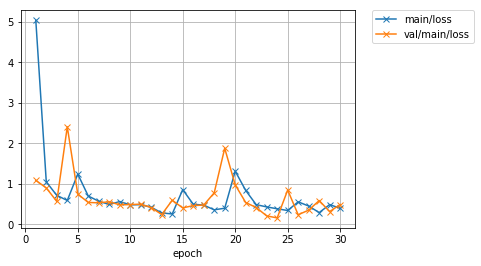

In [0]:
from IPython.display import Image
Image('results/iris_result1/loss.png')

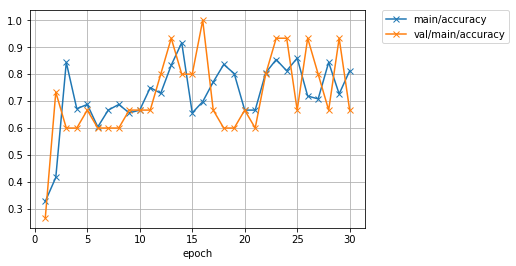

In [0]:
Image('results/iris_result1/accuracy.png')

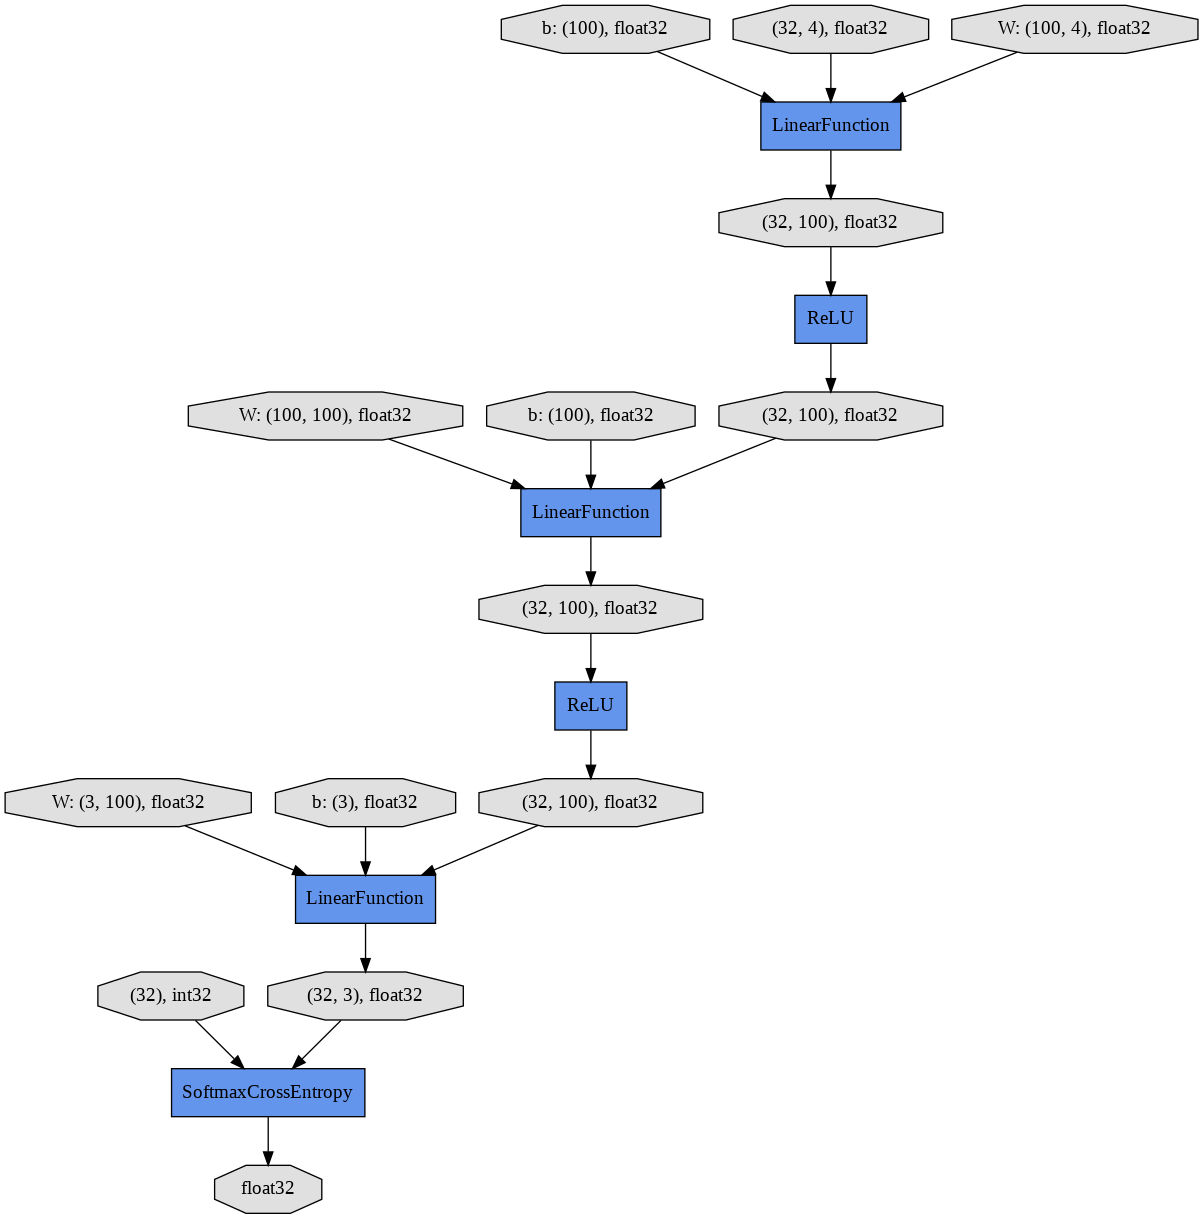

In [0]:
import pydot

file = pydot.graph_from_dot_file('results/iris_result1/cg.dot')
file[0].write_png('graph.png')
Image('graph.png', width=600, height=600)

In [0]:
from chainer import reporter

class MLP2(chainer.Chain):
  
  def __init__(self, n_mid_units=100, n_out=3):
    super().__init__()
    
    with self.init_scope():
      self.fc1 = L.Linear(None, n_mid_units)
      self.fc2 = L.Linear(n_mid_units, n_mid_units)
      self.fc3 = L.Linear(n_mid_units, n_out)
      
  def forward(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    reporter.report({'avg_y': F.average(h), 'var_y': F.cross_covariance(h, h)}, self)
    h = self.fc3(h)
    return h

In [0]:
net = L.Classifier(MLP2())

optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

train_iter = iterators.SerialIterator(train, 32)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)

trainer = training.Trainer(updater, (30, 'epoch'))

In [0]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'main/accuracy', 'main/predictor/avg_y', 'main/predictor/var_y',
]
))

In [0]:
trainer.run()

epoch       iteration   main/accuracy  main/predictor/avg_y  main/predictor/var_y
1           4           0.234375       0.986105              529.368               
2           7           0.5            0.126785              2.35884               
3           10          0.65625        0.206511              26.9549               
4           14          0.78125        0.244888              146.77                
5           17          0.71875        0.270013              428.998               
6           20          0.854167       0.231154              863.922               
7           23          0.614583       0.187626              876.144               
8           27          0.695312       0.155698              501.813               
9           30          0.854167       0.198446              396.286               
10          33          0.604167       0.259462              470.709               
11          37          0.5            0.221242              1548.14          

In [0]:
net = L.Classifier(MLP())

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)

In [0]:
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [0]:
from chainer.training.triggers import EarlyStoppingTrigger

trigger = EarlyStoppingTrigger(monitor='val/main/loss', check_trigger=(1, 'epoch'), patients=5, max_trigger=(30, 'epoch'))
trainer = training.Trainer(updater, trigger, out='results/iris_result5')

In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport([
    'epoch', 'main/loss', 'main/accuracy',
    'val/main/loss', 'val/main/accuracy', 'elapsed_time']))

In [0]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           18.6646     0.359375       0.768851       0.6                0.0414428     
2           1.39877     0.4375         1.06459        0.466667           0.45507       
3           1.31344     0.53125        1.49244        0.6                0.82907       
4           0.88969     0.578125       0.750953       0.466667           1.27358       
5           0.724447    0.65625        1.96967        0.266667           1.65696       
6           1.35955     0.489583       1.13426        0.6                2.11044       
7           0.674042    0.75           0.659538       0.6                2.52096       
8           1.85447     0.414062       1.21899        0.4                2.92972       
9           1.31049     0.28125        1.08852        0.4                3.34016       
10          91.2623     0.364583       1.09862        0.4                3.75925       
11          1.11363     0.3125    

In [0]:
!ls results/iris_result5

accuracy.png  log  loss.png


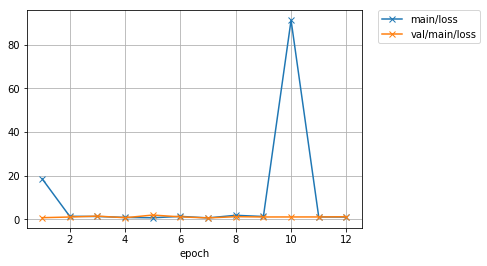

In [0]:
Image('results/iris_result5/loss.png')

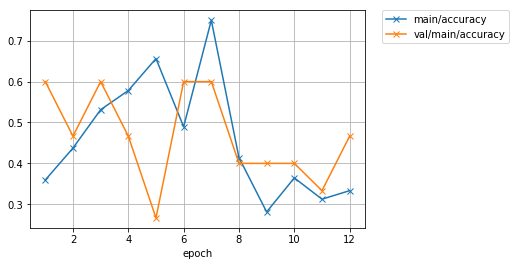

In [0]:
Image('results/iris_result5/accuracy.png')